In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/originaldata/train_data/train_data_0.pq
/kaggle/input/originaldata/train_data/train_data_9.pq
/kaggle/input/originaldata/train_data/train_data_5.pq
/kaggle/input/originaldata/train_data/train_data_4.pq
/kaggle/input/originaldata/train_data/train_data_2.pq
/kaggle/input/originaldata/train_data/train_data_10.pq
/kaggle/input/originaldata/train_data/train_data_3.pq
/kaggle/input/originaldata/train_data/train_data_8.pq
/kaggle/input/originaldata/train_data/train_data_6.pq
/kaggle/input/originaldata/train_data/train_data_11.pq
/kaggle/input/originaldata/train_data/train_data_1.pq
/kaggle/input/originaldata/train_data/train_data_7.pq
/kaggle/input/target/train_target.csv
/kaggle/input/ml-ds-full/train_res.parquet


In [ ]:
import zipfile
import os
import csv
import gc
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,  LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.neural_network import MLPClassifier


from sklearn.metrics import roc_auc_score,roc_curve, RocCurveDisplay, auc, make_scorer, ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import GradientBoostingClassifier,  HistGradientBoostingClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.inspection import permutation_importance
import torch
import torch.utils.data as data_utils
import torch.nn as nn

In [ ]:
df = pd.read_parquet('/kaggle/input/originaldata/train_data/train_data_0.pq')
df.head()

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,...,0,0,0,4,1,2,3,1,1,1
3,0,4,4,1,9,12,16,7,12,2,...,3,3,3,4,1,3,1,1,0,0
4,0,5,5,12,15,2,11,12,10,2,...,3,3,3,4,1,3,4,1,0,0


In [ ]:
for i in df.columns:
    print(i, df[i].nunique())


id 250000
rn 51
pre_since_opened 20
pre_since_confirmed 18
pre_pterm 18
pre_fterm 17
pre_till_pclose 17
pre_till_fclose 16
pre_loans_credit_limit 20
pre_loans_next_pay_summ 7
pre_loans_outstanding 5
pre_loans_total_overdue 1
pre_loans_max_overdue_sum 3
pre_loans_credit_cost_rate 14
pre_loans5 8
pre_loans530 15
pre_loans3060 5
pre_loans6090 3
pre_loans90 4
is_zero_loans5 2
is_zero_loans530 2
is_zero_loans3060 2
is_zero_loans6090 2
is_zero_loans90 2
pre_util 20
pre_over2limit 20
pre_maxover2limit 20
is_zero_util 2
is_zero_over2limit 2
is_zero_maxover2limit 2
enc_paym_0 4
enc_paym_1 4
enc_paym_2 4
enc_paym_3 4
enc_paym_4 4
enc_paym_5 4
enc_paym_6 4
enc_paym_7 4
enc_paym_8 4
enc_paym_9 4
enc_paym_10 4
enc_paym_11 4
enc_paym_12 4
enc_paym_13 4
enc_paym_14 4
enc_paym_15 4
enc_paym_16 4
enc_paym_17 4
enc_paym_18 4
enc_paym_19 4
enc_paym_20 4
enc_paym_21 4
enc_paym_22 4
enc_paym_23 4
enc_paym_24 4
enc_loans_account_holder_type 7
enc_loans_credit_status 7
enc_loans_credit_type 6
enc_loans_accou

In [ ]:
df.isna().any().sum()

0

In [ ]:
#pre_loans_total_overdue содержит 1 значение, можно игнорировать
#также я считаю, что дата сбора данных (оператором) никак не может влиять на внесение/невнесение денег клиентом, и даже если бы какие-то корреляции улавливались, это только шумы,
#которые будут сбивать модель. Поэтому стоит от них сразу избавиться тоже

cols_to_drop = ['pre_since_opened', 'pre_since_confirmed', 'pre_till_pclose', 'pre_till_fclose', 'pre_loans_total_overdue']

In [ ]:
features_paym = ['enc_paym_0', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7', 'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11',
            'enc_paym_12', 'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16', 'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20', 'enc_paym_21', 'enc_paym_22',
            'enc_paym_23', 'enc_paym_24']

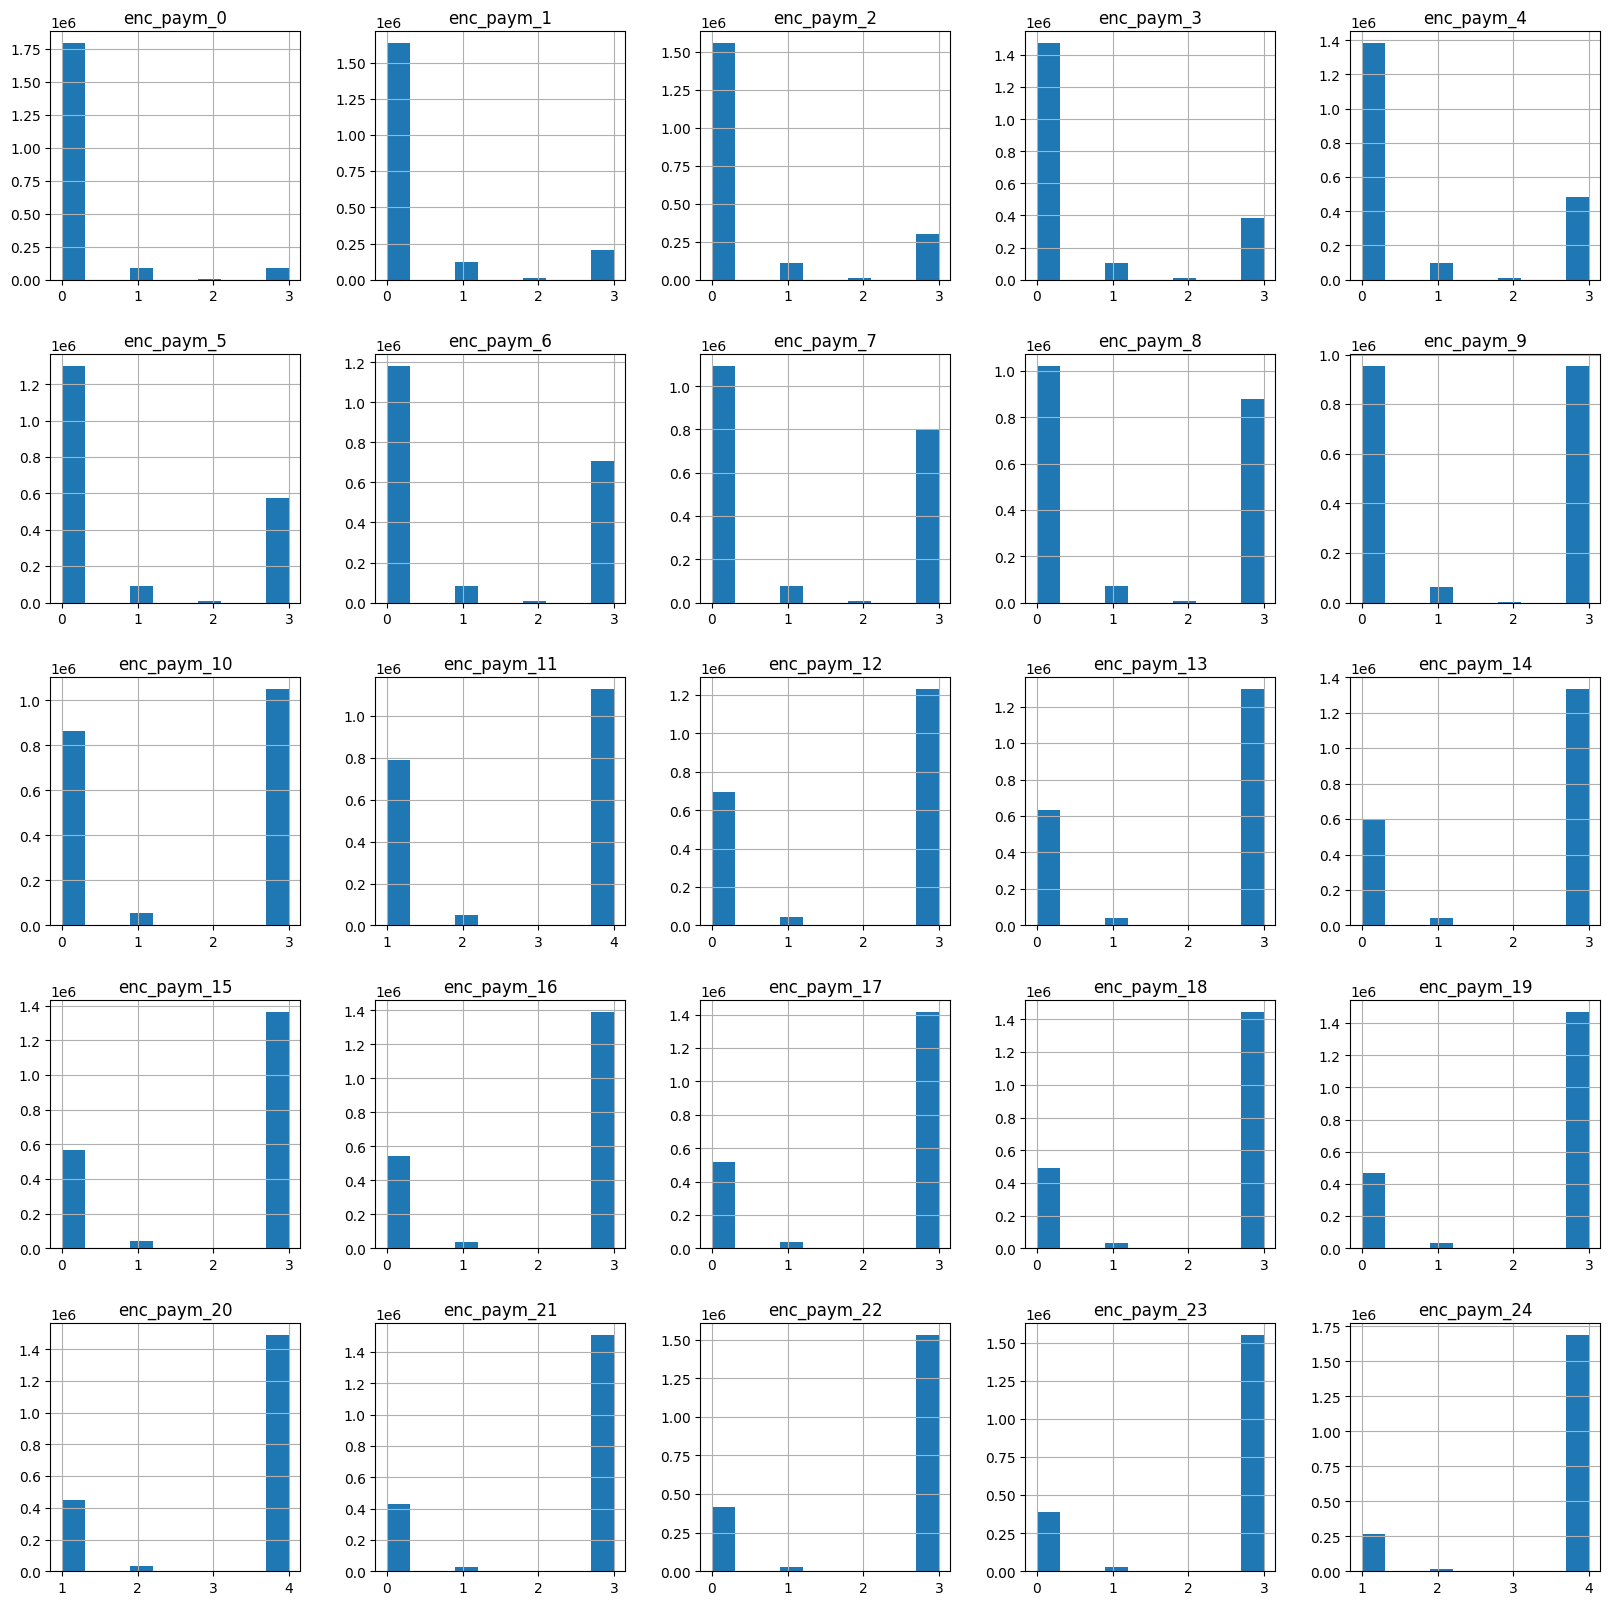

In [ ]:
df.hist(column=features_paym, figsize=(20, 20));

In [ ]:
#у ряда enc_paym значения  сдвинуты на 1, считаю, что это ошибка
def payments(data):
    features_paym = ['enc_paym_0', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7', 'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11',
            'enc_paym_12', 'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16', 'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20', 'enc_paym_21', 'enc_paym_22',
            'enc_paym_23', 'enc_paym_24']

    data[['enc_paym_11', 'enc_paym_20', 'enc_paym_24' ]] = data[['enc_paym_11', 'enc_paym_20', 'enc_paym_24' ]].replace([1, 2, 3, 4], [0, 1 , 2, 3])
    return data

In [ ]:
#Очевидная тактика - перекодировать значения категорию с помощью OHE и агрегировать по id
columns_to_ohe = df.columns.tolist()
columns_to_ohe.remove('id')
columns_to_ohe.remove('rn')
columns_to_ohe = list(set(columns_to_ohe) - set(cols_to_drop))
df[columns_to_ohe].dtypes

enc_paym_4                       int64
enc_paym_11                      int64
pre_loans6090                    int64
pre_loans530                     int64
pre_maxover2limit                int64
enc_paym_2                       int64
pre_loans_max_overdue_sum        int64
is_zero_loans530                 int64
enc_paym_9                       int64
enc_paym_17                      int64
enc_loans_credit_status          int64
enc_paym_8                       int64
enc_paym_18                      int64
enc_paym_21                      int64
pre_loans_credit_cost_rate       int64
enc_paym_3                       int64
is_zero_loans3060                int64
pclose_flag                      int64
enc_paym_22                      int64
enc_paym_16                      int64
enc_paym_6                       int64
pre_loans_next_pay_summ          int64
enc_paym_5                       int64
enc_paym_24                      int64
pre_loans3060                    int64
is_zero_loans6090        

In [ ]:
ohe = OneHotEncoder(sparse_output=False)

In [ ]:
def ohe_prep(data, cols):

    ohe_ds = ohe.fit_transform(data[cols])
    ohe_features = ohe.get_feature_names_out()
    data = data.join(pd.DataFrame(ohe_ds, columns = ohe_features, index=data.index)).drop(cols, axis=1)
    return data

In [ ]:
def aggregate_prep(data):
    columns_to_sum = list(data.columns)
    columns_to_sum.remove('rn')
    columns_to_sum.remove('id')
    aux = {k:'sum' for k in columns_to_sum}
    aux['rn'] = 'max'
    data = data.groupby('id').aggregate(aux)
    data[columns_to_sum]=data[columns_to_sum].astype('int8')
    return data

In [ ]:
cols_to_read = df.columns.tolist()
for i in cols_to_drop:
    cols_to_read.remove(i)

In [ ]:
import os
import tqdm



def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                     num_parts_to_read: int = 2, columns=None, verbose=False) -> pd.DataFrame:
    """
    читает num_parts_to_read партиций, преобразовывает их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой нужно начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                              if filename.startswith('train')])
    print(dataset_paths)

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
    for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):
        print('chunk_path', chunk_path)
        chunk = pd.read_parquet(chunk_path,columns=cols_to_read)
        res.append(chunk)

    return pd.concat(res).reset_index(drop=True)

In [ ]:
def prepare_transactions_dataset(path_to_dataset: str, num_parts_to_preprocess_at_once: int = 1, num_parts_total: int=50,
                                 save_to_path=None, verbose: bool=False):
    """
    возвращает готовый pd.DataFrame с признаками, на которых можно учить модель для целевой задачи
    path_to_dataset: str
        путь до датасета с партициями
    num_parts_to_preprocess_at_once: int
        количество партиций, которые будут одновременно держаться и обрабатываться в памяти
    num_parts_total: int
        общее количество партиций, которые нужно обработать
    save_to_path: str
        путь до папки, в которой будет сохранён каждый обработанный блок в .parquet-формате; если None, то не будет сохранён
    verbose: bool
        логирует каждую обрабатываемую часть данных
    """
    preprocessed_frames = []

    for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                                   desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once,
                                                             verbose=verbose)

        transactions_frame = payments(transactions_frame)
        transactions_frame = ohe_prep(transactions_frame, columns_to_ohe)
        transactions_frame = aggregate_prep(transactions_frame)
        gc.collect()




   #записываем подготовленные данные в файл
        if save_to_path:
            block_as_str = str(step)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            transactions_frame.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))

        preprocessed_frames.append(transactions_frame)
    return pd.concat(preprocessed_frames)

In [ ]:
data0 = prepare_transactions_dataset('/kaggle/input/originaldata/train_data', num_parts_to_preprocess_at_once=1, num_parts_total=12,
                                    save_to_path='/kaggle/working/')

In [ ]:
for i in data0.columns:
    if data0[i].isna().sum() > 0:
        print(i, data0[i].isna().sum())

pre_loans530_7 250000
pre_loans530_11 750000
pre_loans6090_3 750000
pre_loans530_19 750000
pre_loans3060_1 250000
pre_loans90_2 500000
pre_loans5_1 250000
pre_loans530_5 2250000
pre_loans3060_6 2250000
pre_loans90_3 1500000
pre_loans90_10 1000000
enc_loans_credit_type_6 1250000
enc_loans_credit_type_7 1250000
pre_loans5_8 1000000
pre_loans5_9 1500000
pre_loans5_11 2250000
pre_loans530_8 2500000
pre_loans530_9 2500000
pre_loans_max_overdue_sum_0 2750000
pre_loans3060_0 2500000
pre_loans3060_3 2750000
pre_loans6090_0 2750000
pre_loans3060_4 2750000
pre_loans530_17 2750000
pre_loans5_10 2750000


In [ ]:
#NaN вылезли из-за того, что некоторые значения отсутствовали в ряде батчей. У нас ohe, поэтому 0
data0.fillna(0, inplace=True)

In [ ]:
target = pd.read_csv('/kaggle/input/target/train_target.csv')
target.shape

(3000000, 2)

In [ ]:
data0 = data0.join(target, on='id', how='inner' )

In [ ]:
data0 = data0.drop('id',axis=1)

In [ ]:
data0.shape

(3000000, 348)

In [ ]:
data0.head()

,enc_paym_4_0,enc_paym_4_1,enc_paym_4_2,enc_paym_4_3,enc_paym_11_0,enc_paym_11_1,enc_paym_11_2,enc_paym_11_3,pre_loans6090_1,pre_loans6090_2,...,pre_loans530_8,pre_loans530_9,pre_loans_max_overdue_sum_0,pre_loans3060_0,pre_loans3060_3,pre_loans6090_0,pre_loans3060_4,pre_loans530_17,pre_loans5_10,flag
id,,,,,,,,,,,,,,,,,,,,,
0,8,0,0,2,5,0,0,5,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,11,0,0,3,7,0,0,7,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2,0,0,1,0,1,0,2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,14,0,0,1,9,0,0,6,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0,0,0,1,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


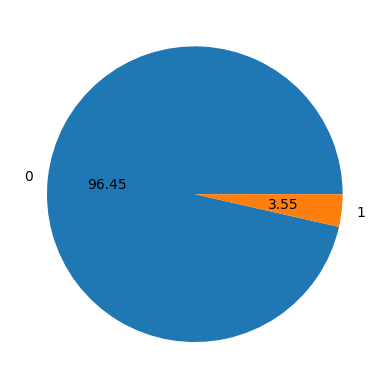

In [ ]:
plt.pie(data0.flag.value_counts(), labels=data0['flag'].unique(), autopct="%.2f");

In [ ]:
train, test = train_test_split(data0, stratify=data0['flag'], test_size=0.2, random_state=17)

In [ ]:
data0.to_parquet('/kaggle/working/data0.parquet')


In [ ]:
train.to_parquet('/kaggle/working/train.parquet')
test.to_parquet('/kaggle/working/test.parquet')

In [ ]:
x_train =train.drop('flag', axis=1)
x_test =test.drop('flag', axis=1)
y_train = train['flag']
y_test = test['flag']

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2400000, 347), (2400000,), (600000, 347), (600000,))

In [ ]:
roc_auc = make_scorer(roc_auc_score)

## Base Gradient Boosting

In [ ]:
grad0=HistGradientBoostingClassifier(class_weight='balanced', scoring='roc_auc')
grad0.fit(x_train, y_train)

HistGradientBoostingClassifier(class_weight='balanced', scoring='roc_auc')

In [ ]:
probs = grad0.predict_proba(x_train)
probs = probs[:, 1]
# рассчитываем ROC AUC
clf_auc = roc_auc_score(y_train, probs)
print('rus ROC AUC=%.3f' % (clf_auc))

probs = grad0.predict_proba(x_test)
probs = probs[:, 1]
# рассчитываем ROC AUC
clf_auc = roc_auc_score(y_test, probs)
print('test ROC AUC=%.3f' % (clf_auc))

rus ROC AUC=0.764
test ROC AUC=0.755


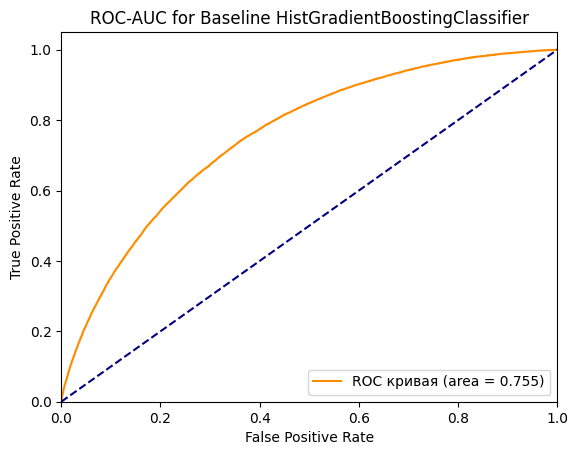

In [ ]:
# рассчитываем кривую ROC AUC
fpr, tpr, treshold = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

# строим график  ROC AUC
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC for Baseline HistGradientBoostingClassifier')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print(classification_report(y_test, grad0.predict(x_test) ))

              precision    recall  f1-score   support

           0       0.98      0.66      0.79    578712
           1       0.07      0.72      0.13     21288

    accuracy                           0.66    600000
   macro avg       0.53      0.69      0.46    600000
weighted avg       0.95      0.66      0.77    600000



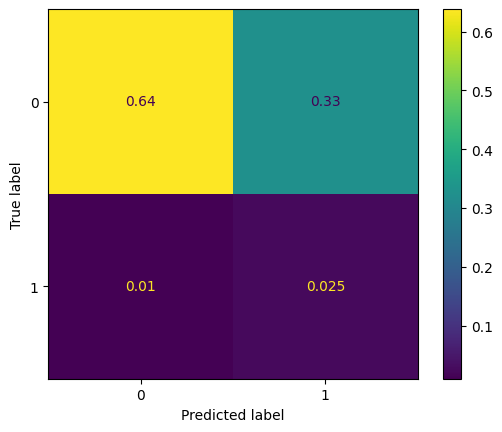

In [ ]:
cm = confusion_matrix(y_test, grad0.predict(x_test), labels=grad0.classes_, normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grad0.classes_)
disp.plot()
plt.show()

In [ ]:
#для ряда экспериментов достаточно и небольшой выборки, поскольку у нас сильный дисбаланс классов, то получим ее с помощью downsampling

rus = RandomUnderSampler(random_state=42)
x_rus, y_rus = rus.fit_resample(x_train, y_train)

In [ ]:
result = permutation_importance(
    grad0, x_rus, y_rus, n_repeats=3, random_state=42, n_jobs=-1, scoring='roc_auc'
)

In [ ]:
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=x_rus.columns[sorted_importances_idx],
)
iter0=importances.columns[importances.lt(0.0001).loc[0]].to_list()
importances = importances.drop(iter0, axis=1)

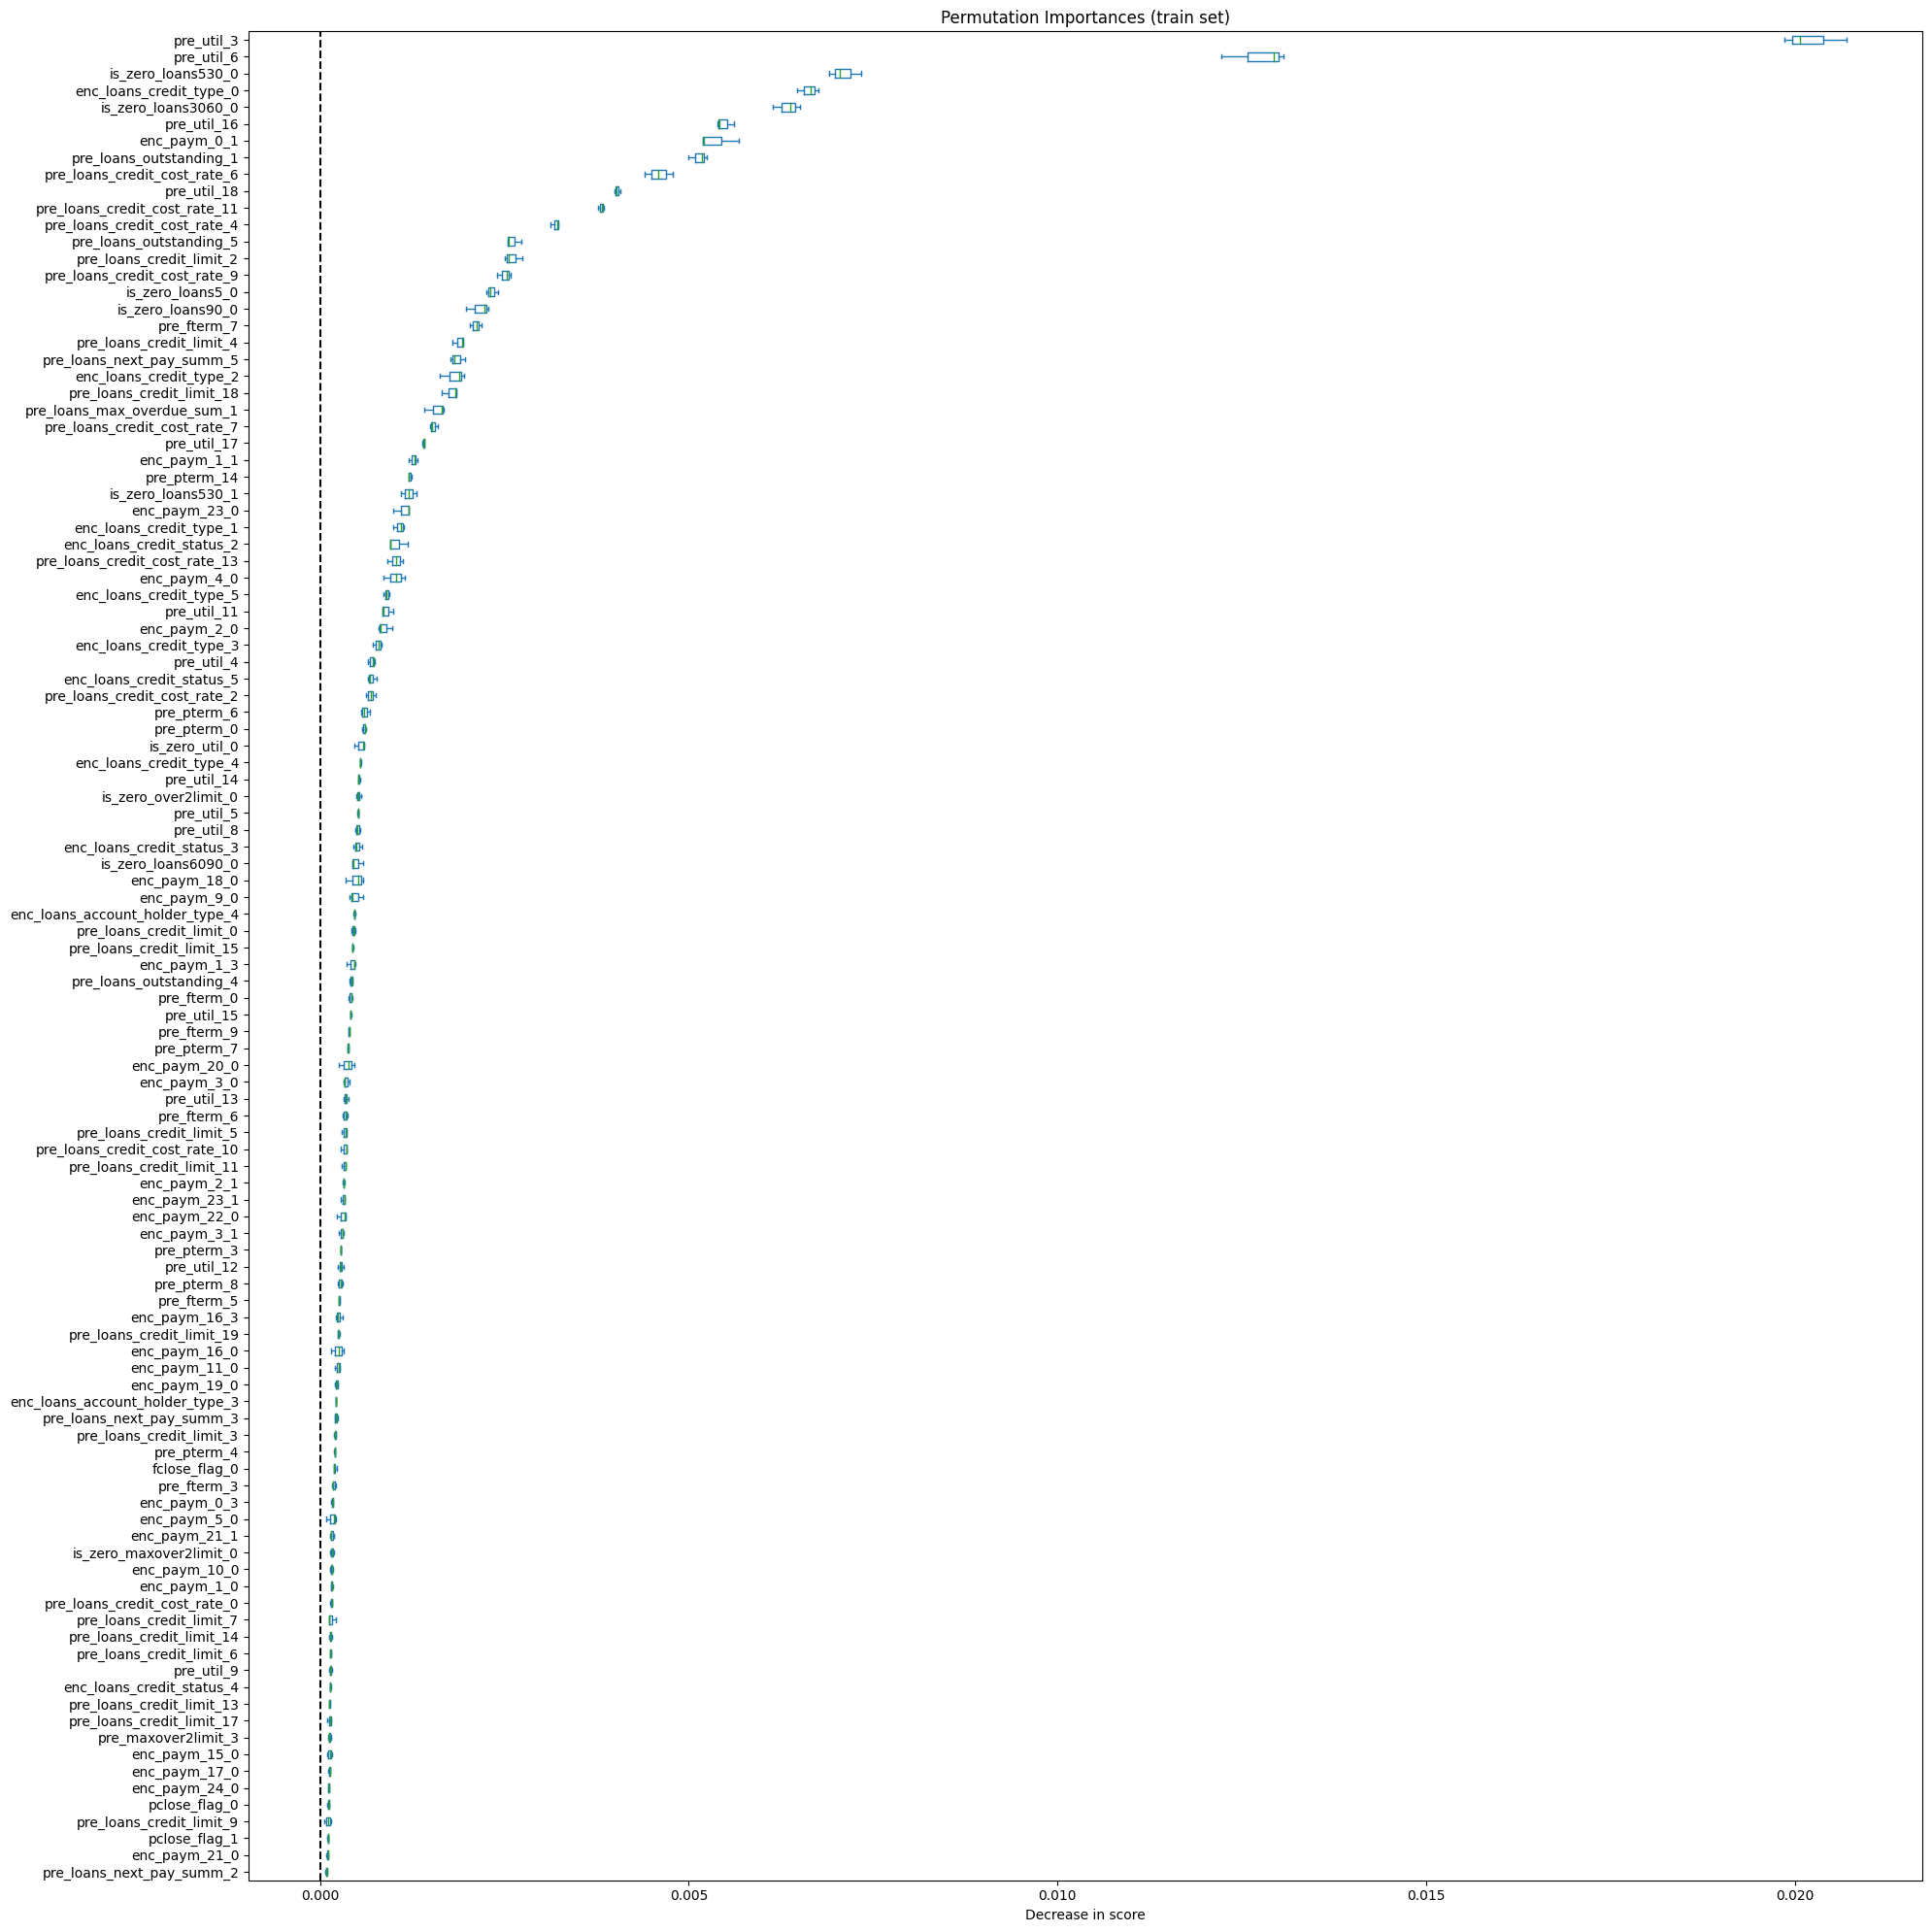

In [ ]:
ax = importances.plot.box(vert=False, whis=10, figsize=(20, 20))
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in score")
ax.figure.tight_layout()

In [ ]:
#проверим тут еще, как модель реагирует на масштабирование данных, на случай, если будем делать ансамбль

In [ ]:
scaler =  StandardScaler()
scaler.fit(x_rus)
x_rus_scaled = scaler.fit_transform(x_rus)
x_test_scaled = scaler.transform(x_test)

In [ ]:
grad0rus = grad0.fit(x_rus, y_rus)
grad0scaled = grad0.fit(x_rus_scaled, y_rus)

In [ ]:
probs = grad0rus.predict_proba(x_test_scaled)
probs = probs[:, 1]
# рассчитываем ROC AUC
clf_auc = roc_auc_score(y_test, probs)
print('rus ROC AUC=%.3f' % (clf_auc))

probs = grad0scaled.predict_proba(x_test_scaled)
probs = probs[:, 1]
# рассчитываем ROC AUC
clf_auc = roc_auc_score(y_test, probs)
print('rus scaled ROC AUC=%.3f' % (clf_auc))

rus ROC AUC=0.753
rus scaled ROC AUC=0.753


In [ ]:
print(classification_report(y_test, grad0rus.predict(x_test_scaled) ))

              precision    recall  f1-score   support

           0       0.98      0.66      0.79    578712
           1       0.07      0.72      0.13     21288

    accuracy                           0.66    600000
   macro avg       0.53      0.69      0.46    600000
weighted avg       0.95      0.66      0.76    600000



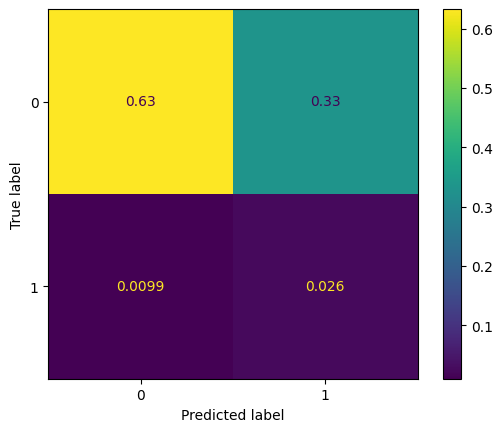

In [ ]:
cm = confusion_matrix(y_test, grad0rus.predict(x_test_scaled), labels=grad0rus.classes_, normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grad0rus.classes_)
disp.plot()
plt.show()

## Base LogisticRegression

In [ ]:
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)

In [ ]:
log_reg.fit(x_rus_scaled, y_rus)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [ ]:
probs = log_reg.predict_proba(x_rus_scaled)
probs = probs[:, 1]
# рассчитываем ROC AUC
clf_auc = roc_auc_score(y_rus, probs)
print('rus ROC AUC=%.3f' % (clf_auc))

probs = log_reg.predict_proba(x_test_scaled)
probs = probs[:, 1]
# рассчитываем ROC AUC
clf_auc = roc_auc_score(y_test, probs)
print('rus scaled ROC AUC=%.3f' % (clf_auc))

rus ROC AUC=0.733
rus scaled ROC AUC=0.729


In [ ]:
print(classification_report(y_test, log_reg.predict(x_test_scaled) ))

              precision    recall  f1-score   support

           0       0.98      0.67      0.79    578712
           1       0.07      0.68      0.13     21288

    accuracy                           0.67    600000
   macro avg       0.53      0.67      0.46    600000
weighted avg       0.95      0.67      0.77    600000



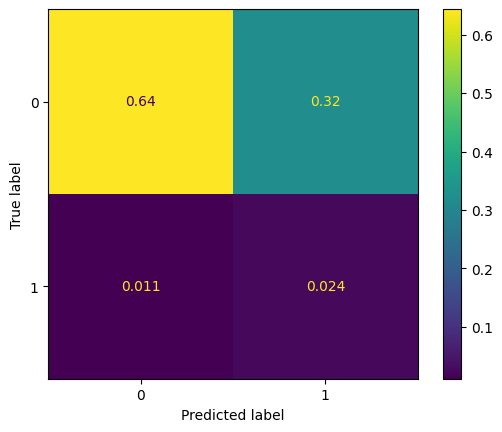

In [ ]:
cm = confusion_matrix(y_test, log_reg.predict(x_test_scaled), labels=log_reg.classes_, normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot()
plt.show()

## Base Torch Net

In [ ]:
from torch.utils.data import Dataset

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.values.astype(np.float32))

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

train_data = MyDataset(x_rus_scaled, y_rus)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32

train_dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

In [ ]:
x_test_tensor = torch.from_numpy(x_test_scaled.astype(np.float32))
y_test_tensor = torch.from_numpy(y_test.values.astype(np.float32))

In [ ]:
class BaseClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.f1 = nn.ReLU()

        self.output = nn.Linear(hidden_dim, output_dim)
        self.f2 = nn.Sigmoid()

    def forward(self, x):
        x = self.f1(self.hidden(x))
        x  = self.f2(self.output(x))

        return x

In [ ]:
basenet = BaseClassifier(347, 231, 1)


loss_fn = nn.BCELoss()

optimizer = torch.optim.SGD(basenet.parameters(), lr=0.01)

num_epochs = 10

loss_values = []
loss_test = []
roc_auc_test = []


In [ ]:
for epoch in range(num_epochs):

    for X, y in train_dataloader:

        pred = basenet(X)

        loss = loss_fn(pred, y.unsqueeze(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



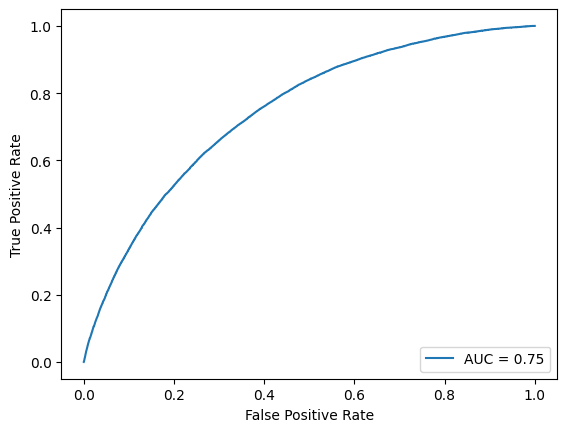

In [ ]:
y_pred_proba = basenet(x_test_tensor).cpu().detach().numpy().ravel()
fpr, tpr, _ = roc_curve(y_test_tensor, y_pred_proba)
roc_auc = auc(fpr, tpr)

RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot();


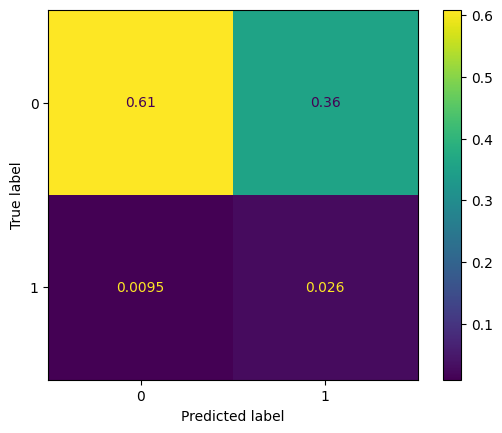

In [ ]:
y_pred = np.round(basenet(x_test_tensor).cpu().detach().numpy().ravel())
cm = confusion_matrix(y_test, y_pred, labels=[0, 1], normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

In [ ]:
#Итого у нас 3 baseline модели, которые без настройки параметров и гиперпараметров и какого-либо feature engineering,
#при грубой балансировке показывают сопоставимое качество.
#При этом модель, полученная с помощью HistGradientBoostingClassifier преодолевает установленный порог метрики 0.75
#Попробуем на этой базе еще поднять метрику и повысить качество извлечения.